In [12]:
import geopandas as gpd
import fiona

fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'
geodata = gpd.read_file('chapter_11_data/chapter 11 data.kml')
geodata = geodata[['Name', 'geometry']]
geodata.head()


,Name,geometry
0,Apt 1,POINT Z (4.88944 52.37603 0.00000)
1,Apt 2,POINT Z (4.88828 52.37486 0.00000)
2,Apt 3,POINT Z (4.88311 52.37163 0.00000)
3,Apt 4,POINT Z (4.88581 52.37493 0.00000)
4,Apt 5,POINT Z (4.88714 52.37163 0.00000)


In [13]:
import pandas as pd
apartment_data = pd.read_excel('chapter_11_data/house_data.xlsx')
apartment_data.head()


,Apt ID,Price,MaxGuests,IncludesBreakfast
0,1,120,4,0
1,2,110,2,0
2,3,115,3,0
3,4,125,4,0
4,5,135,3,0


In [14]:
apartment_data['Apt ID'] = apartment_data['Apt ID'].apply(lambda x: 'Apt ' + str(x))
apartment_data.head()


,Apt ID,Price,MaxGuests,IncludesBreakfast
0,Apt 1,120,4,0
1,Apt 2,110,2,0
2,Apt 3,115,3,0
3,Apt 4,125,4,0
4,Apt 5,135,3,0


In [15]:
merged_data = geodata.merge(apartment_data, left_on='Name', right_on='Apt ID')
merged_data.head()


,Name,geometry,Apt ID,Price,MaxGuests,IncludesBreakfast
0,Apt 1,POINT Z (4.88944 52.37603 0.00000),Apt 1,120,4,0
1,Apt 2,POINT Z (4.88828 52.37486 0.00000),Apt 2,110,2,0
2,Apt 3,POINT Z (4.88311 52.37163 0.00000),Apt 3,115,3,0
3,Apt 4,POINT Z (4.88581 52.37493 0.00000),Apt 4,125,4,0
4,Apt 5,POINT Z (4.88714 52.37163 0.00000),Apt 5,135,3,0


KeyboardInterrupt: 

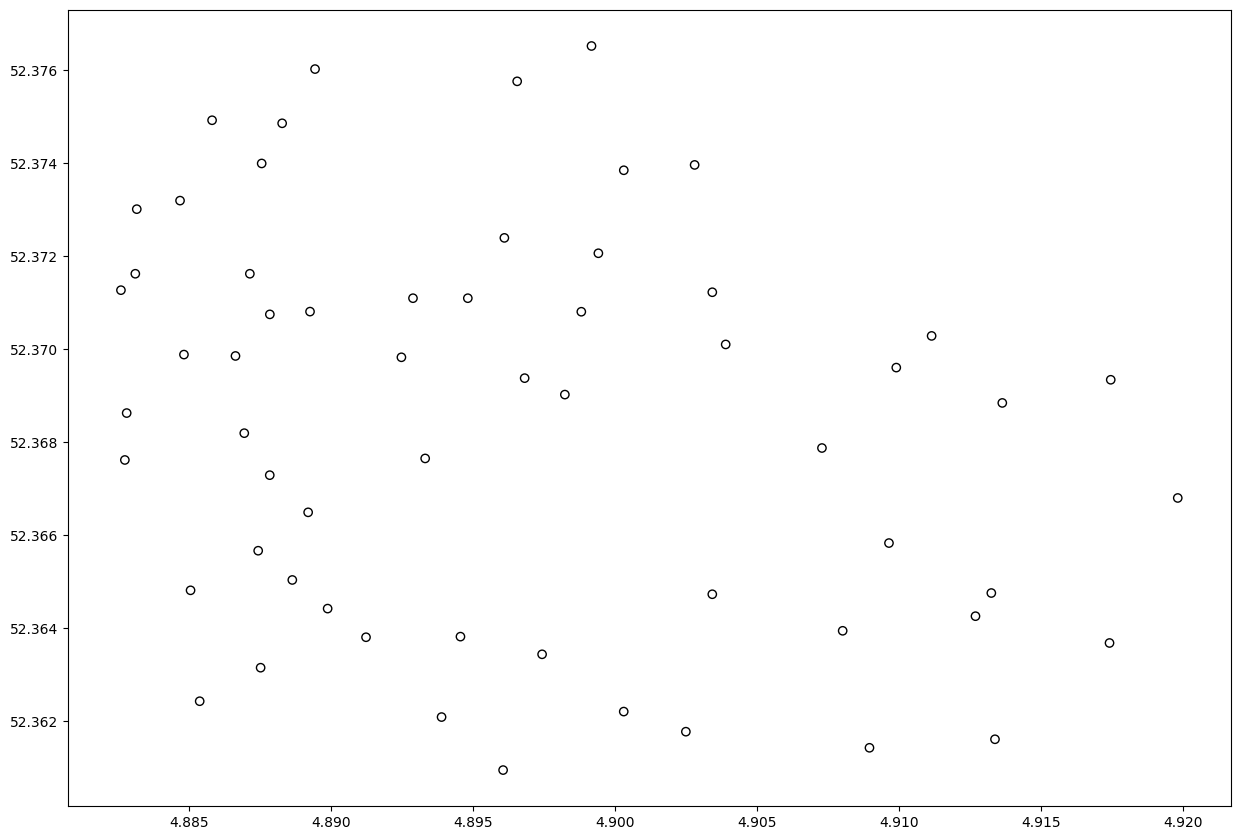

In [16]:
import contextily as cx

# plotting all data
ax = merged_data.plot(figsize=(15,15), edgecolor='black', facecolor='none')

# adding a contextily basemap
cx.add_basemap(ax, crs=merged_data.crs)


(array([ 1.,  5.,  3., 10.,  2., 11., 10.,  9.,  8.,  1.]),
 array([ 90.,  98., 106., 114., 122., 130., 138., 146., 154., 162., 170.]),
 <BarContainer object of 10 artists>)

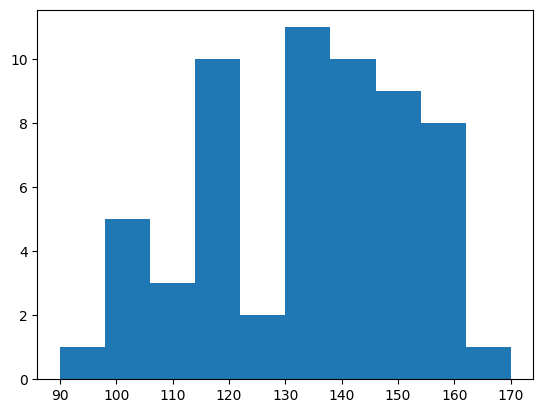

In [17]:
import matplotlib.pyplot as plt
plt.hist(merged_data['Price'])


In [18]:
# if we had no info to segment at all, our best guest would be to predict the mean
merged_data['Price'].mean()


133.75

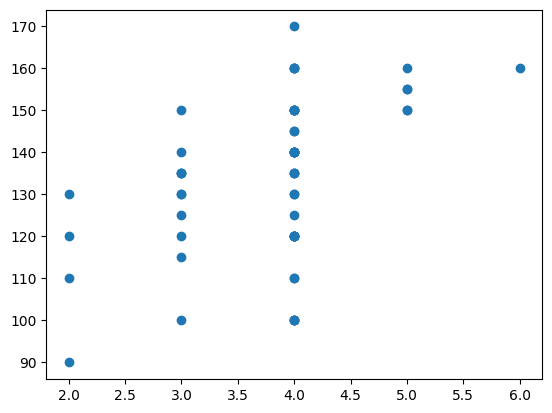

In [19]:
# however we may use additional information to make this estimate more fitting
plt.scatter(merged_data['MaxGuests'], merged_data['Price'])


In [20]:
import numpy as np
np.corrcoef(merged_data['MaxGuests'], merged_data['Price'])


array([[1.        , 0.45366546],
       [0.45366546, 1.        ]])

<AxesSubplot:xlabel='IncludesBreakfast', ylabel='Price'>

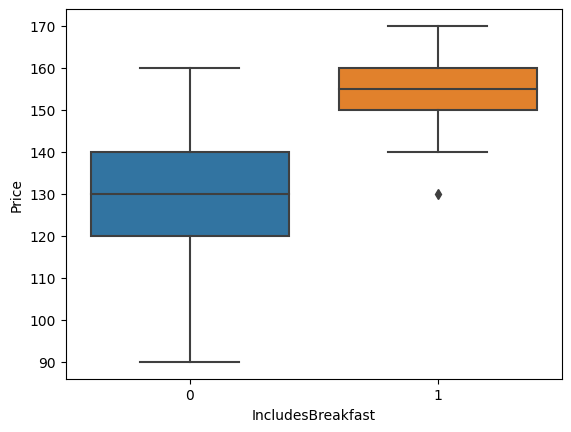

In [21]:
import seaborn as sns
sns.boxplot(x='IncludesBreakfast',y='Price',data=merged_data)


In [22]:
X = merged_data[['IncludesBreakfast', 'MaxGuests']]
y = merged_data['Price']


In [23]:
# first version lets just do a quick and dirty non geo model
from sklearn.linear_model import LinearRegression
lin_reg_1 = LinearRegression()
lin_reg_1.fit(X, y)


LinearRegression()

In [24]:
print('When no breakfast and 0 Max Guests then price is estimated at: ', lin_reg_1.intercept_)

print('Adding breakfast adds to the price: ', lin_reg_1.coef_[0])

print('Each additional Max Guests adds to the price: ', lin_reg_1.coef_[1])


When no breakfast and 0 Max Guests then price is estimated at:  103.13654447286162
Adding breakfast adds to the price:  16.615515771526002
Each additional Max Guests adds to the price:  7.254546746234725


In [25]:
# Evaluate this model a bit better with train test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [26]:
lin_reg_2 = LinearRegression()
lin_reg_2.fit(X_train, y_train)


LinearRegression()

In [27]:
pred_reg_2 = lin_reg_2.predict(X_test)

In [28]:
from sklearn.metrics import r2_score
r2_score(y_test, pred_reg_2)


0.10073506908318419

In [29]:
# add the geo data and see whether it imporves thing
merged_data['long'] = merged_data['geometry'].apply(lambda x: x.x)
merged_data['lat'] = merged_data['geometry'].apply(lambda x: x.y)
merged_data.head()


,Name,geometry,Apt ID,Price,MaxGuests,IncludesBreakfast,long,lat
0,Apt 1,POINT Z (4.88944 52.37603 0.00000),Apt 1,120,4,0,4.889439,52.376029
1,Apt 2,POINT Z (4.88828 52.37486 0.00000),Apt 2,110,2,0,4.888281,52.374863
2,Apt 3,POINT Z (4.88311 52.37163 0.00000),Apt 3,115,3,0,4.883109,52.371628
3,Apt 4,POINT Z (4.88581 52.37493 0.00000),Apt 4,125,4,0,4.885813,52.374929
4,Apt 5,POINT Z (4.88714 52.37163 0.00000),Apt 5,135,3,0,4.887143,52.371628


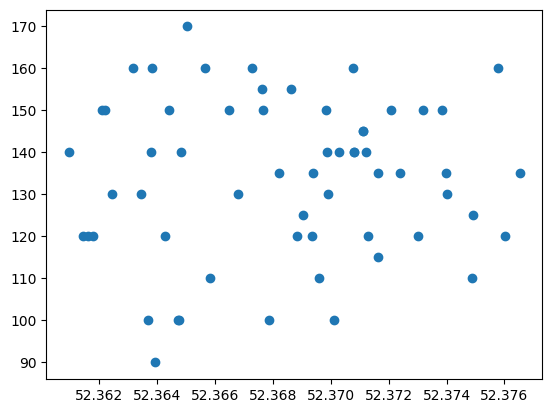

In [30]:
plt.scatter(merged_data['lat'], merged_data['Price'])

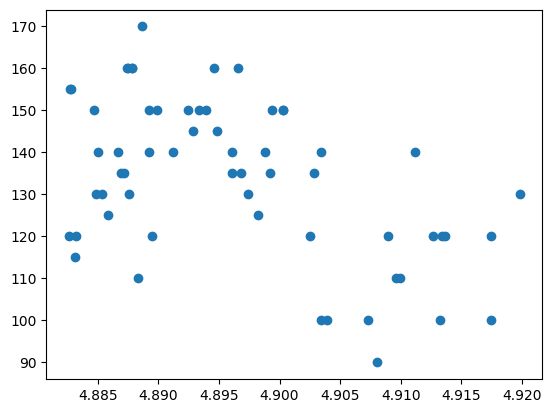

In [31]:
plt.scatter(merged_data['long'], merged_data['Price'])

In [32]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(16, 512))
merged_data[['MarkerSize']] = scaler.fit_transform(merged_data[['Price']])


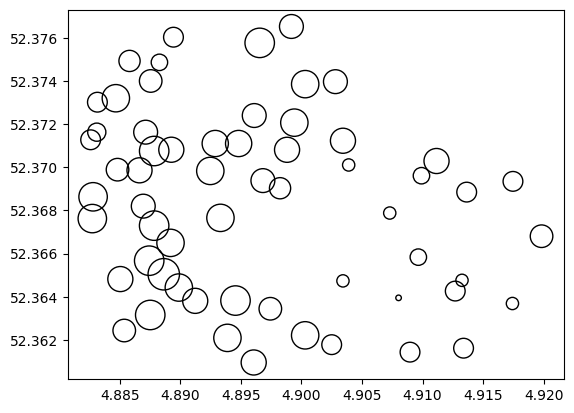

In [33]:
plt.scatter(merged_data['long'], merged_data['lat'], s=merged_data['MarkerSize'], c='none', edgecolors='black')

In [34]:
# add features
X2 = merged_data[['IncludesBreakfast', 'MaxGuests', 'lat', 'long']]
y = merged_data['Price']

# train test split
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.33, random_state=42)

# build the model
lin_reg_3 = LinearRegression()
lin_reg_3.fit(X2_train, y_train)

# evaluate the model
pred_reg_3 = lin_reg_3.predict(X2_test)
print(r2_score(y_test, pred_reg_3))


0.49804563214638187


In [36]:
from sklearn.tree import DecisionTreeRegressor

# build the model
dt_reg_4 = DecisionTreeRegressor()
dt_reg_4.fit(X2_train, y_train)

# evaluate the model
pred_reg_4 = dt_reg_4.predict(X2_test)
print(r2_score(y_test, pred_reg_4))


-0.0451306413301662


In [37]:
# tune this model a little bit

for max_depth in range(1,11):

    # build the model
    dt_reg_5 = DecisionTreeRegressor(max_depth=max_depth)
    dt_reg_5.fit(X2_train, y_train)

    # evaluate the model
    pred_reg_5 = dt_reg_5.predict(X2_test)
    print(max_depth, r2_score(y_test, pred_reg_5))


1 0.4132332385169546
2 0.3524351192047155
3 0.5448849007360488
4 0.4387428700696431
5 0.15716547901821065
6 0.08972991994369706
7 -0.04829770387965171
8 0.03263833905164071
9 -0.0451306413301662
10 0.2082343626286619


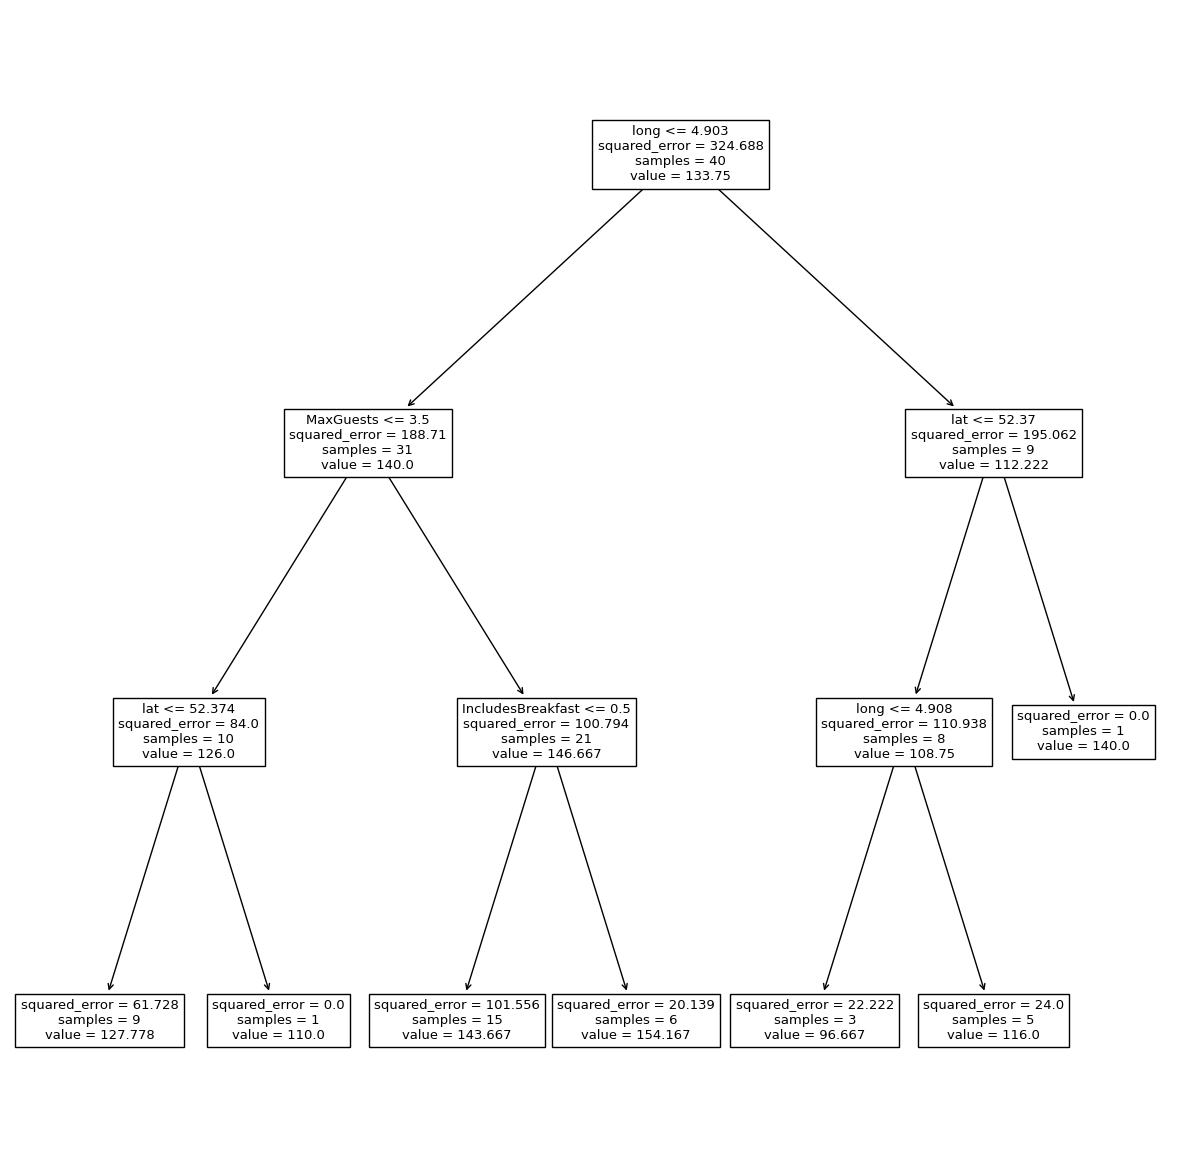

In [38]:
from sklearn import tree

# build the model
dt_reg_5 = DecisionTreeRegressor(max_depth=3)
dt_reg_5.fit(X2_train, y_train)

plt.figure(figsize=(15,15))
tree.plot_tree(dt_reg_5, feature_names=X2_train.columns)
plt.show()
